In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [2]:
dataset_cremad_dir = "./Dataset/CREMAD/AudioWAV"
crema_dir_list = os.listdir(dataset_cremad_dir)
print(len(crema_dir_list))

7442


In [3]:
emotion_dict = {
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fear",
    "HAP": "happy",
    "NEU": "neutral",
    "SAD": "sad"
}

emotion_list = []
path_list = []

for audio_file in crema_dir_list:
    emotion_segment = audio_file.split("_")[2]

    audio_file_path = os.path.join(dataset_cremad_dir, audio_file);

    path_list.append(audio_file_path)
    
    if emotion_segment in emotion_dict:
        emotion_list.append(emotion_dict[emotion_segment])
    else:
        emotion_list.append("unknown")

cremad_df = pd.DataFrame({'Emotion': emotion_list, 'Path': path_list})
cremad_df.to_csv("crema_df.csv", index = False)
cremad_df.head()

,Emotion,Path
0,angry,./Dataset/CREMAD/AudioWAV\1001_DFA_ANG_XX.wav
1,disgust,./Dataset/CREMAD/AudioWAV\1001_DFA_DIS_XX.wav
2,fear,./Dataset/CREMAD/AudioWAV\1001_DFA_FEA_XX.wav
3,happy,./Dataset/CREMAD/AudioWAV\1001_DFA_HAP_XX.wav
4,neutral,./Dataset/CREMAD/AudioWAV\1001_DFA_NEU_XX.wav


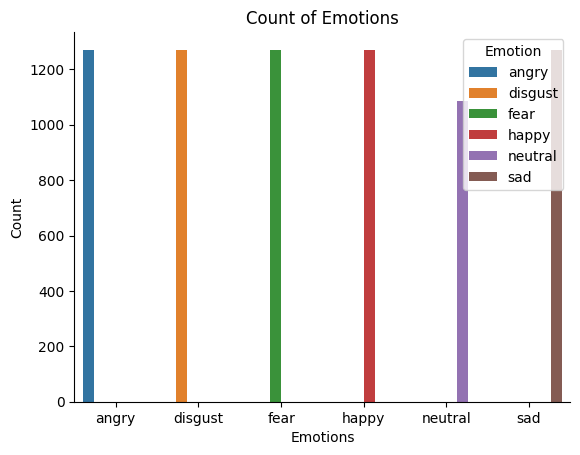

In [4]:
plt.title('Count of Emotions')
sns.countplot(x = cremad_df.Emotion, hue = cremad_df.Emotion)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [5]:
def waveplot(data, sr, emo):
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, emo):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

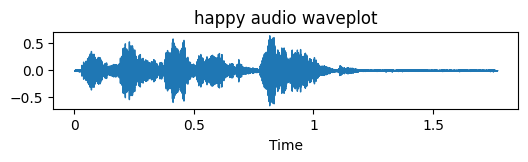

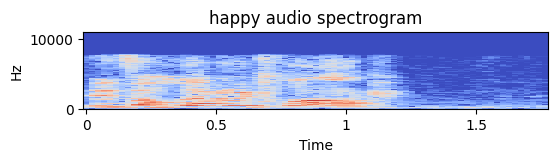

In [6]:
emotion = 'happy'

audio_file_path = np.array(cremad_df.Path[cremad_df.Emotion == emotion])[1]
data, sampling_rate = librosa.load(audio_file_path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(audio_file_path)

In [7]:
def noise(data):
  noise_amp = 0.035 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def time_stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data, steps_range = (-5, 5)):
  shift_range = int(np.random.uniform(steps_range[0], steps_range[1]) * 1000)
  return np.roll(data, shift_range)

def pitch_shift(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

def random_time_stretch(data, stretch_factor_range = (0.8, 1.25)):
  random_stretch_factor = np.random.uniform(stretch_factor_range[0], stretch_factor_range[1])

  augmented_data = time_stretch(data, random_stretch_factor)

  if len(augmented_data) > len(data):
    augmented_data = augmented_data[:len(data)]
  else:
    padded_augmented_data = np.zeros_like(data)
    padded_augmented_data[:len(augmented_data)] = augmented_data
    augmented_data = padded_augmented_data

  return augmented_data

def random_pitch_shift(data, sampling_rate, steps_range=(-4, 4)):
  n_steps = np.random.randint(steps_range[0], steps_range[1] + 1)  
  return pitch_shift(data, sampling_rate, n_steps)

In [8]:
def extract_mel(data, sr, n_mels=128, fmax=8000):
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    return mel_spec;

def extract_log_mel_spec(data, sr, n_mels=128, fmax=8000):
    log_mel_spec = librosa.power_to_db(extract_mel(data, sr, n_mels, fmax))
    return log_mel_spec;

def extract_mfcc(data, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc=n_mfcc)
    return mfcc;

def extract_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    return delta_mfcc;

def extract_delta_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return delta2_mfcc;

def extract_zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    return zcr

def extract_rms(data):
    rms = librosa.feature.rms(y=data)
    return rms

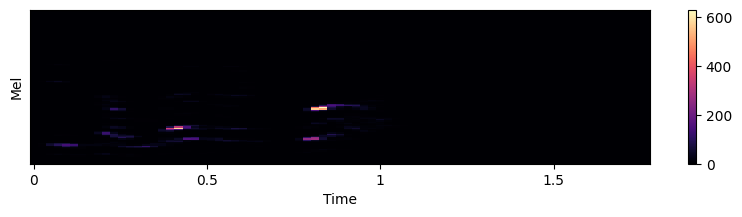

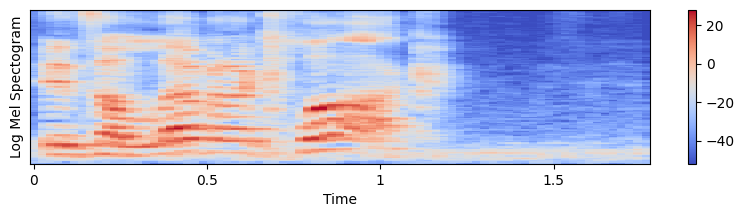

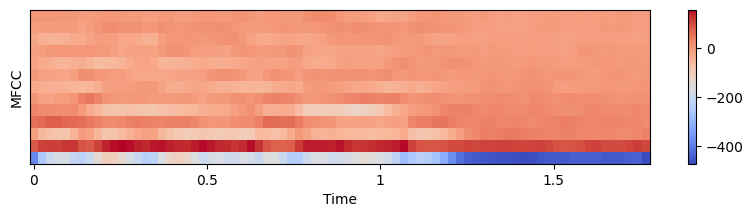

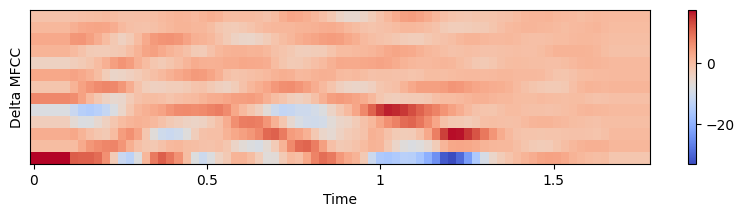

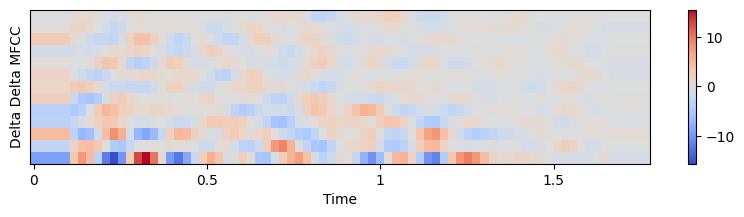

In [9]:
mel = extract_mel(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mel, x_axis='time', sr = sampling_rate)
plt.ylabel('Mel')
plt.colorbar()

log_mel_spec = extract_log_mel_spec(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(log_mel_spec, x_axis='time', sr = sampling_rate)
plt.ylabel('Log Mel Spectogram')
plt.colorbar()

# MFCC
mfcc = extract_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('MFCC')
plt.colorbar()

# ΔMFCC
delta_mfcc = extract_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta MFCC')
plt.colorbar()

# ΔΔMFCC
delta_delta_mfcc = extract_delta_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta Delta MFCC')
plt.colorbar()
plt.show()

# MFCC-based approximate entropy
# MFCC-based spectral entropy
# Three-dimensional Mel-scale frequency cepstral coefficients

In [10]:
# feature_extraction_techniques = ["MFCC", "Delta MFCC", "Delta Delta MFCC"]
feature_extraction_techniques = ["MFCC Mean 20", "MFCC Min 20", "MFCC Max 20", "MFCC Standard Deviation 20"]

file_name_feat_extract = " & ".join(feature_extraction_techniques)

def extract_features(data, sr):
    # MEAN
    features = np.array([])
    mfcc = extract_mfcc(data, sr, 20).T
    mfcc_mean = np.mean(mfcc, axis=0)
    mfcc_min = np.min(mfcc, axis=0)
    mfcc_max = np.max(mfcc, axis=0)
    mfcc_std = np.std(mfcc, axis=0)
    # zcr = np.mean(extract_zcr(data))
    # rms = np.mean(extract_rms(data))
    features = np.hstack((features, mfcc_mean, mfcc_min, mfcc_max, mfcc_std))

    # ENTIRE FEATURE
    # mfcc = extract_mfcc(data, sr).T
    # delta_mfcc = extract_delta_mfcc(data, sr).T
    # delta_delta_mfcc = extract_delta_delta_mfcc(data, sr).T
    # features = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc), axis=1)
    
    return features

In [11]:
# data_augmentation_techniques = ["Noise", "Random Time Stretch", "Random Pitch Shift"]
data_augmentation_techniques = ["Noise", "Low Speed 0.7", "High Speed 1.25", "Pitch Shift 0.8", "Shift -4 4"]
file_name_data_aug = " & ".join(data_augmentation_techniques)

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)

    noisy_data = noise(data)

    lowspeed_data = time_stretch(data, rate=0.7) #Ignore this
    highspeed_data = time_stretch(data, rate=1.25) #Ignore this
    pitch_shift_data = pitch_shift(data, sampling_rate, n_steps=0.8) #Ignore this
    shift_data = shift(data, (-4, 4)) #Ignore this

    random_time_stretch_data = random_time_stretch(data, (0.8, 1.25))
    random_pitch_shift_data = random_pitch_shift(data, sampling_rate, (-4, 4))

    features = extract_features(data, sampling_rate)
    noisy_features = extract_features(noisy_data, sampling_rate)
    
    lowspeed_features = extract_features(lowspeed_data, sampling_rate) #Ignore this
    highspeed_features = extract_features(highspeed_data, sampling_rate) #Ignore this
    pitch_shift_features = extract_features(pitch_shift_data, sampling_rate) #Ignore this
    shift_features = extract_features(shift_data, sampling_rate) #Ignore this

    random_time_stretch_features = extract_features(random_time_stretch_data, sampling_rate)
    random_pitch_shift_features = extract_features(random_pitch_shift_data, sampling_rate)

    # result = np.vstack((features, noisy_features, random_time_stretch_features, random_pitch_shift_features))
    result = np.vstack((features, noisy_features, lowspeed_features, highspeed_features, pitch_shift_features, shift_features))

    return result

In [12]:
filename = file_name_feat_extract + " # " + file_name_data_aug

def create_feature_dataframe(dataframe):
    feature_list = []
    emotion_list = []

    for path, emotion in tqdm(zip(dataframe.Path, dataframe.Emotion), total=len(dataframe)):
        features = get_features(path)
        for elements in features:
            feature_list.append(elements)
            emotion_list.append(emotion)

    df = pd.DataFrame({'Emotion': emotion_list})
    df = pd.concat([df, pd.DataFrame(feature_list)], axis=1)
    df.to_csv(filename + '.csv', index=False)

    return df

In [13]:
file_exists = os.path.exists(filename + '.csv')

if file_exists:
    df = pd.read_csv(filename + '.csv')
else:
    df = create_feature_dataframe(cremad_df)

df.head()

,Emotion,0,1,2,3,4,5,6,7,8,...,70,71,72,73,74,75,76,77,78,79
0,angry,-333.451996,125.097977,-18.162201,45.336807,-4.580707,19.655285,-24.719402,-2.889565,-12.300763,...,7.351497,6.735706,7.912274,9.143975,13.267700,7.071219,8.530931,6.925933,4.796985,7.101593
1,angry,-178.955035,32.964459,3.571910,10.794941,8.519149,0.466835,-7.185190,-9.791943,-5.765213,...,5.561629,4.956973,5.658392,5.799608,7.266606,4.231153,7.212712,4.129811,3.923734,5.444328
2,angry,-362.946808,117.330391,-16.022707,41.909611,-1.807477,16.203703,-22.493589,-4.768125,-11.727188,...,7.343813,6.971950,7.634371,8.994743,13.412138,7.267824,7.921823,5.805368,4.701189,7.552429
3,angry,-357.486511,124.096321,-20.568272,45.309425,-6.201471,19.024982,-26.162035,-2.946156,-13.089823,...,5.925484,7.227911,7.595479,9.055154,14.267176,7.133223,8.166162,5.816387,4.530529,6.699092
4,angry,-359.286987,119.484962,-17.851772,44.138172,-5.689456,15.750453,-30.231760,-2.441793,-13.553227,...,7.947981,9.403915,6.504251,7.267365,11.026600,8.549662,7.470093,5.807473,5.586038,7.575805


In [14]:
X = df.iloc[:, 1:].values
Y = df['Emotion'].values

In [15]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31256, 80), (31256, 6), (13396, 80), (13396, 6))

In [17]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31256, 80), (31256, 6), (13396, 80), (13396, 6))

In [18]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [19]:
def create_model(model_type, epochs):
    model = Sequential()
    
    if model_type == 'GRU':
        model.add(GRU(128, input_shape=(X_train.shape[1],1), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(GRU(128, return_sequences=True))
        model.add(GRU(128))
    elif model_type == 'LSTM':
        model.add(LSTM(128, input_shape=(X_train.shape[1],1), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
    elif model_type == 'BiGRU':
        model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(GRU(128)))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.3))
        model.add(Bidirectional(LSTM(128)))
    elif model_type == 'CNN':
        model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(128, 3, activation='relu'))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(256, 3, activation='relu'))
        model.add(MaxPooling1D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
    else:
        raise ValueError("Invalid RNN model. Choose from 'GRU', 'LSTM', 'BiGRU', 'BiLSTM', or 'CNN'.")

    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.00001)
    checkpoint = ModelCheckpoint(model_type + " # " + filename + '.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stop, checkpoint])

    model.save(model_type + '.h5')    
    
    return model, history

In [20]:
def evaluate_model(model):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

In [21]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [22]:
model_lstm, history_lstm = create_model("LSTM", 10)
model_gru, history_gru = create_model("GRU", 10)
model_bilstm, history_bilstm = create_model("BiLSTM", 10)
model_bigru, history_bigru = create_model("BiGRU", 10)
model_cnn, history_cnn = create_model("CNN", 10)

Epoch 1/10
488/489 [============================>.] - ETA: 0s - loss: 1.5346 - accuracy: 0.3641
Epoch 1: val_accuracy improved from -inf to 0.39803, saving model to LSTM # MFCC Mean 20 & MFCC Min 20 & MFCC Max 20 & MFCC Standard Deviation 20 # Noise & Low Speed 0.7 & High Speed 1.25 & Pitch Shift 0.8 & Shift -4 4.h5
489/489 [==============================] - 36s 57ms/step - loss: 1.5346 - accuracy: 0.3641 - val_loss: 1.4876 - val_accuracy: 0.3980 - lr: 0.0010
Epoch 2/10
488/489 [============================>.] - ETA: 0s - loss: 1.4722 - accuracy: 0.3937
Epoch 2: val_accuracy improved from 0.39803 to 0.40475, saving model to LSTM # MFCC Mean 20 & MFCC Min 20 & MFCC Max 20 & MFCC Standard Deviation 20 # Noise & Low Speed 0.7 & High Speed 1.25 & Pitch Shift 0.8 & Shift -4 4.h5
489/489 [==============================] - 24s 49ms/step - loss: 1.4721 - accuracy: 0.3938 - val_loss: 1.4637 - val_accuracy: 0.4047 - lr: 0.0010
Epoch 3/10
489/489 [==============================] - ETA: 0s - loss:

419/419 [==============================] - 20s 48ms/step - loss: 1.3157 - accuracy: 0.4620
Test Loss: 1.3156743049621582
Test Accuracy: 0.46200358867645264


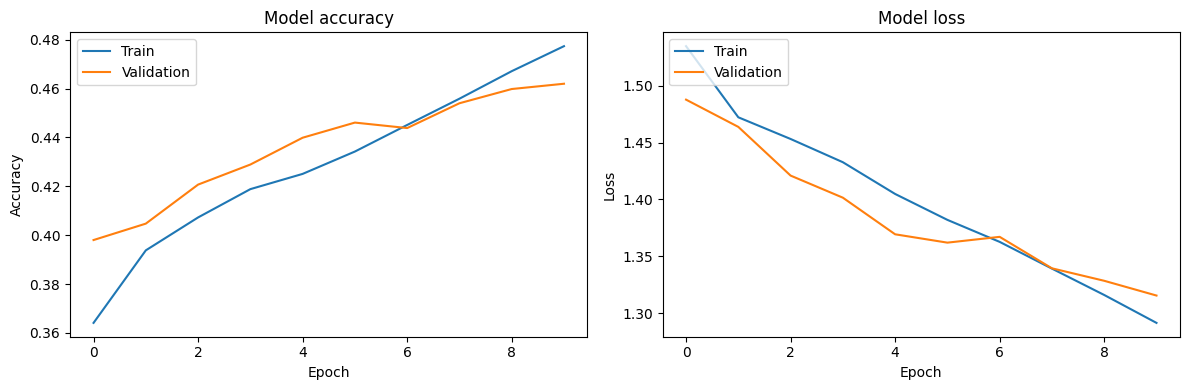

In [23]:
evaluate_model(model_lstm)
plot_history(history_lstm)

419/419 [==============================] - 17s 40ms/step - loss: 1.2447 - accuracy: 0.5008
Test Loss: 1.2446740865707397
Test Accuracy: 0.5008211135864258


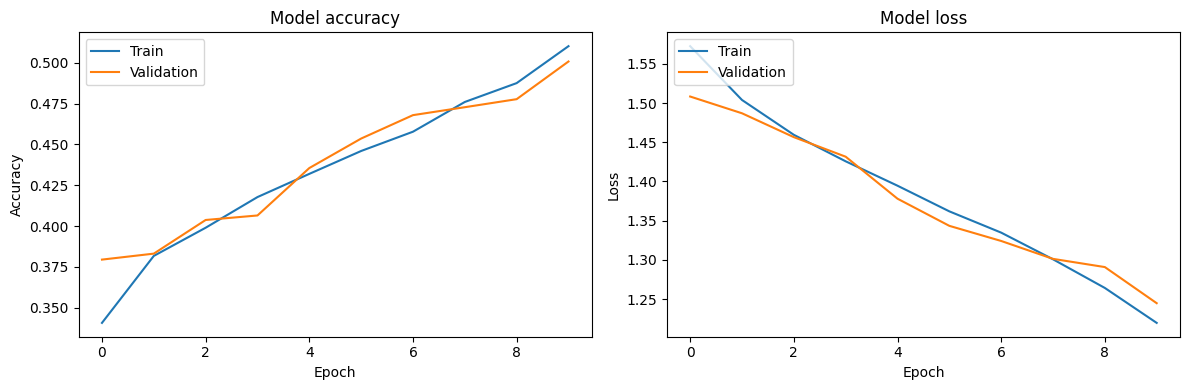

In [24]:
evaluate_model(model_gru)
plot_history(history_gru)

419/419 [==============================] - 25s 60ms/step - loss: 1.1279 - accuracy: 0.5567
Test Loss: 1.1279414892196655
Test Accuracy: 0.5567333698272705


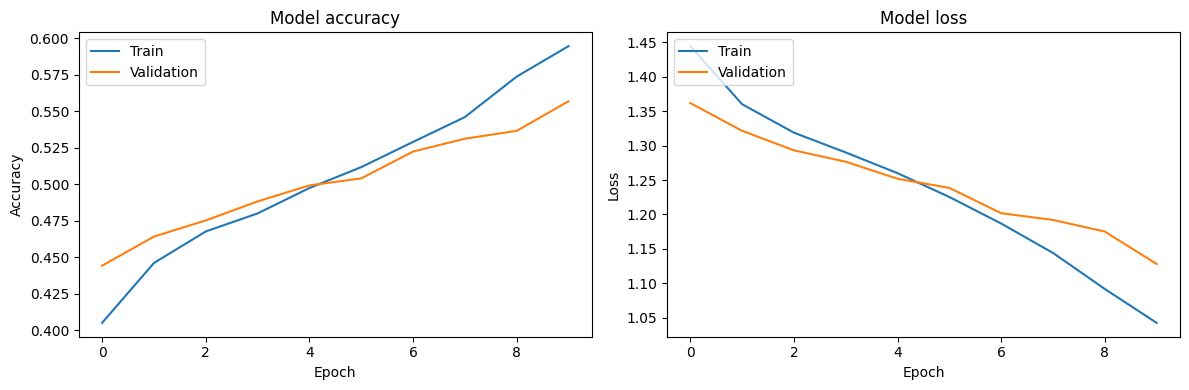

In [25]:
evaluate_model(model_bilstm)
plot_history(history_bilstm)

419/419 [==============================] - 27s 64ms/step - loss: 1.0957 - accuracy: 0.5741
Test Loss: 1.09568452835083
Test Accuracy: 0.5741266012191772


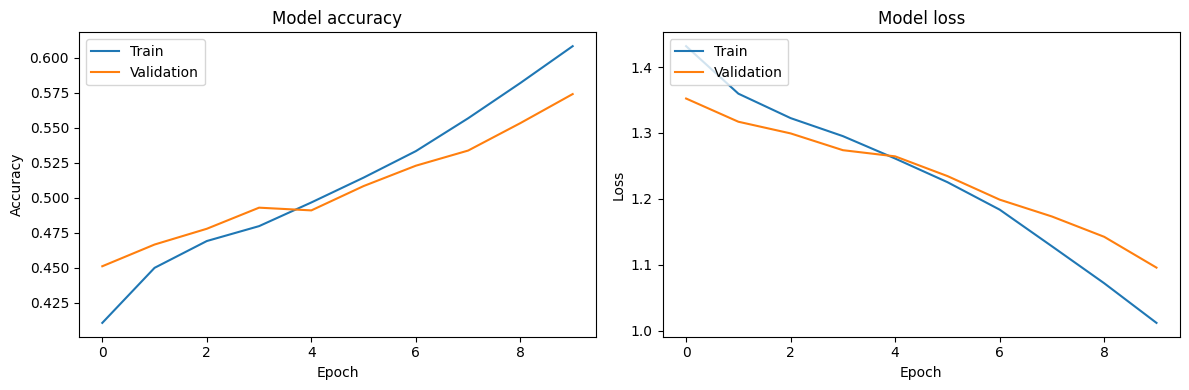

In [26]:
evaluate_model(model_bigru)
plot_history(history_bigru)

419/419 [==============================] - 3s 7ms/step - loss: 0.9818 - accuracy: 0.7250
Test Loss: 0.9817916750907898
Test Accuracy: 0.7249925136566162


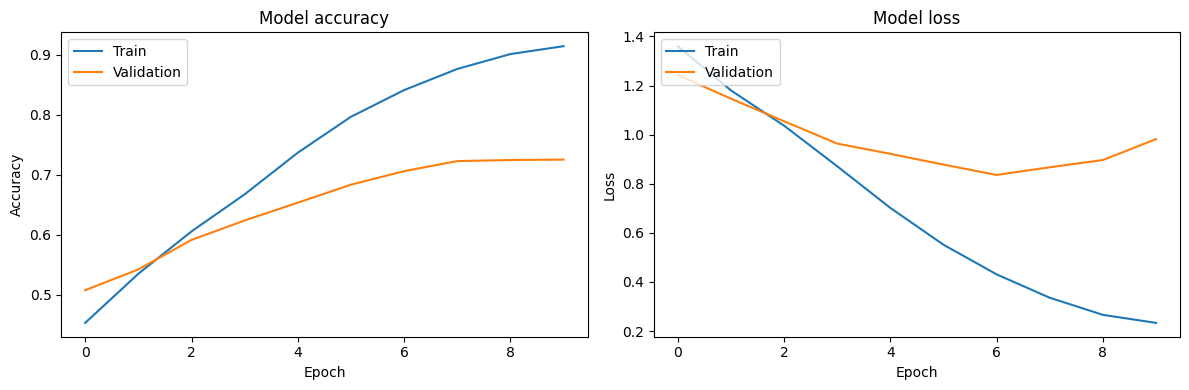

In [27]:
evaluate_model(model_cnn)
plot_history(history_cnn)